MovieWriter ffmpeg unavailable; using Pillow instead.


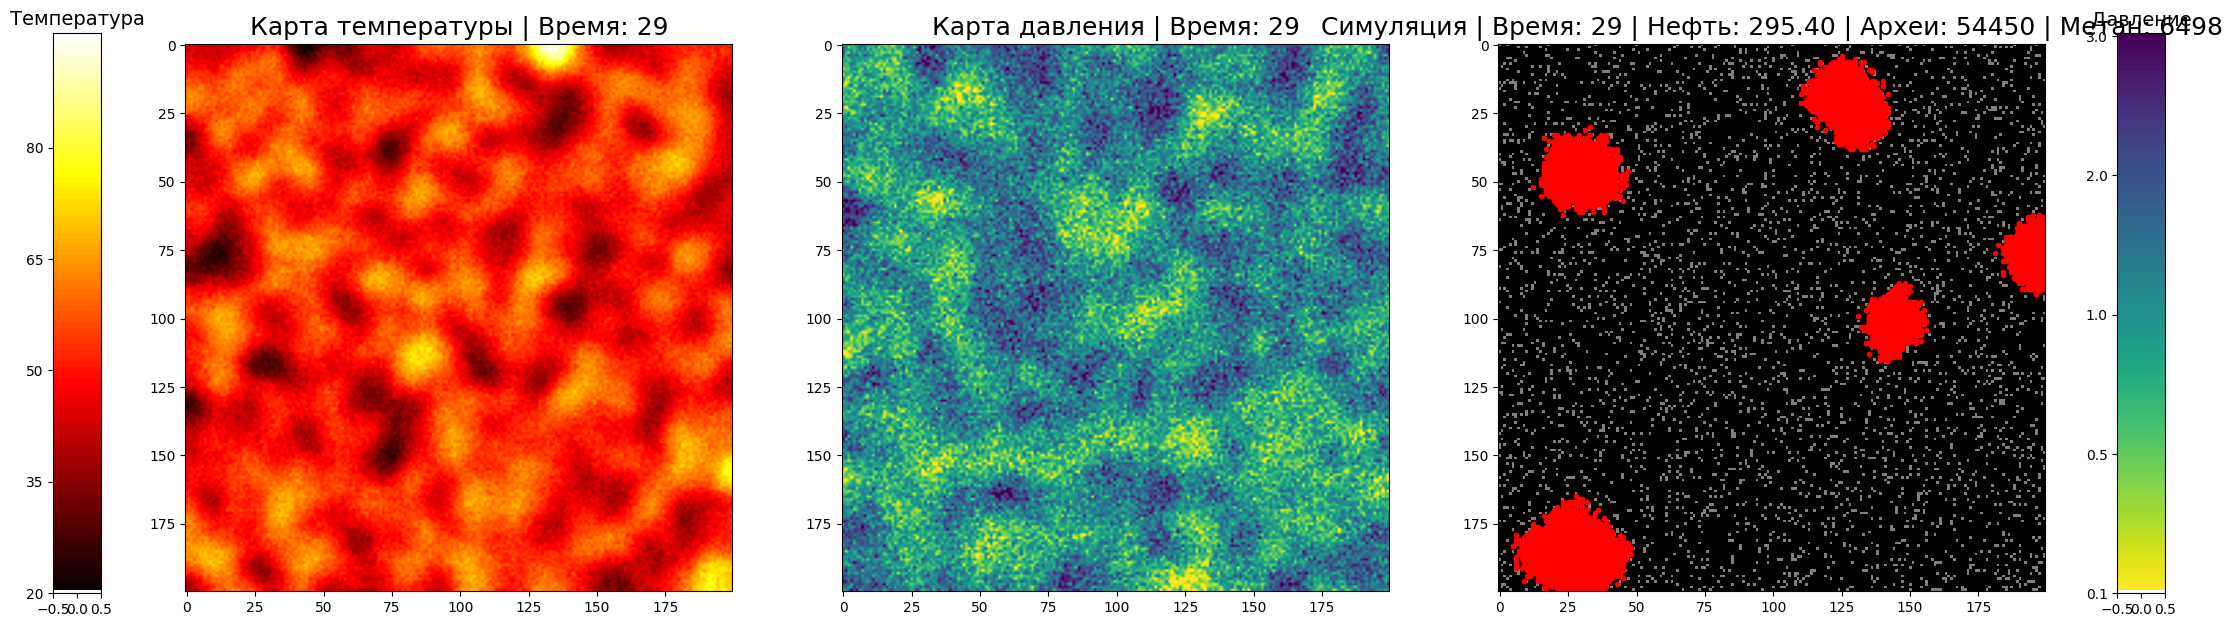

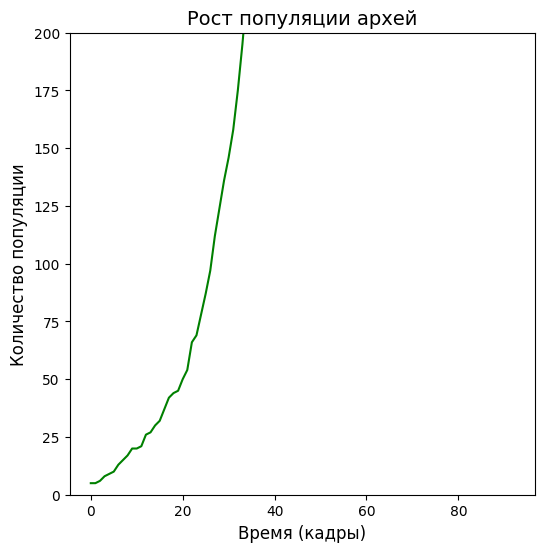

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
import random
from scipy.ndimage import gaussian_filter

# Параметры
GRID_SIZE = 200  # Размер сетки
INITIAL_ARCHEA_COUNT = 5  # Начальное количество архей
OIL_DENSITY = 0.9  # Плотность нефти в сетке
METHANE_DENSITY = 0.5  # Плотность метана
ARCHEA_MOVEMENT_PROBABILITY = 0.5  # Вероятность движения архей
ARCHEA_REPRODUCTION_PROBABILITY = 0.1  # Вероятность размножения архей
CONSUMPTION_RADIUS = 6  # Радиус потребления нефти вокруг архей
STARVATION_FRAMES = 20  # Количество кадров без нефти перед смертью архей

# Условия выживания архей
OPTIMAL_TEMPERATURE = (30, 60)  # Оптимальная температура в градусах Цельсия
OPTIMAL_PRESSURE = (0.5, 2)  # Оптимальное давление в атмосферах

# Создание сетки
grid = np.random.rand(GRID_SIZE, GRID_SIZE) < OIL_DENSITY  # Сетка нефти
temperature_map = gaussian_filter(np.random.uniform(20, 80, (GRID_SIZE, GRID_SIZE)), sigma=5)  # Температура от 20 до 80°C
pressure_map = gaussian_filter(np.random.uniform(0.1, 3, (GRID_SIZE, GRID_SIZE)), sigma=5)  # Давление от 0.1 до 3 атм

# Функция для инициализации позиций архей и метана на основе плотности нефти и условий
def initialize_positions(initial_count, grid, temperature_map, pressure_map):
    oil_density_map = np.zeros_like(grid, dtype=float)

    # Вычисление плотности нефти вокруг каждой ячейки
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            if grid[x, y]:  # Если есть нефть
                for dx in range(-1, 2):
                    for dy in range(-1, 2):
                        if 0 <= x + dx < GRID_SIZE and 0 <= y + dy < GRID_SIZE:
                            oil_density_map[x + dx, y + dy] += 1

    # Получение позиций с максимальной плотностью нефти 
    oil_positions = np.argwhere(oil_density_map > 0)

    # Фильтрация позиций по условиям температуры и давления
    suitable_positions_archea = []
    suitable_positions_methane = []
    for pos in oil_positions:
        x, y = pos
        if (OPTIMAL_TEMPERATURE[0] <= temperature_map[x, y] <= OPTIMAL_TEMPERATURE[1] and
                OPTIMAL_PRESSURE[0] <= pressure_map[x, y] <= OPTIMAL_PRESSURE[1]):
            suitable_positions_archea.append(pos)
            if random.random() < METHANE_DENSITY:
                suitable_positions_methane.append(pos)

    # Если нет достаточного количества подходящих позиций для архей, выдать ошибку
    if len(suitable_positions_archea) == 0:
        raise ValueError("No suitable positions for spawning archaea.")

    # Случайный выбор уникальных начальных позиций из подходящих позиций для архей и метана
    selected_indices_archea = np.random.choice(len(suitable_positions_archea), size=min(initial_count, len(suitable_positions_archea)), replace=False)
    selected_indices_methane = np.random.choice(len(suitable_positions_methane), size=min(initial_count, len(suitable_positions_methane)), replace=False)

    return np.array(suitable_positions_archea)[selected_indices_archea], np.array(suitable_positions_methane)[selected_indices_methane]

# Инициализация позиций архей и метана
archea_positions, methane_positions = initialize_positions(INITIAL_ARCHEA_COUNT, grid, temperature_map, pressure_map)

# Создание фигуры и осей для анимации
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
ax1.set_title("Карта температуры", fontsize=14)
ax2.set_title("Карта давления", fontsize=14)
ax3.set_title("Симуляция архей и метана", fontsize=14)
cmap_temp = plt.get_cmap('hot')  # Цвета для температуры (теплая палитра)
cmap_archea = ListedColormap(['grey', 'black'])  # Цвета для архей (серый для метана и черный для нефти)

# Отображение карты температуры и давления
temp_plot = ax1.imshow(temperature_map, cmap=cmap_temp, interpolation='bilinear')
pressure_plot = ax2.imshow(pressure_map, interpolation='bilinear')

# Отображение сетки с нефтью и археями и метаном
oil_plot = ax3.imshow(grid, cmap=cmap_archea, interpolation='nearest')
methane_plot, = ax3.plot(methane_positions[:, 1], methane_positions[:, 0], 'go', markersize=3)   # Метан зеленым цветом
archea_plot, = ax3.plot(archea_positions[:, 1], archea_positions[:, 0], 'ro', markersize=3)      # Археи красным цветом

# Добавление цветовых шкал для температуры и давления
temp_bar = fig.add_axes([0.07, 0.15, 0.02, 0.7])
temp_bar.set_title("Температура", fontsize=14)
temp_bar.imshow(np.linspace(80, 20, 100).reshape(100, 1), cmap=cmap_temp, aspect='auto')
temp_bar.set_yticks([100, 80, 60, 40, 20])
temp_bar.set_yticklabels([20, 35, 50, 65, 80])

pressure_bar = fig.add_axes([0.93, 0.15, 0.02, 0.7])
pressure_bar.set_title("Давление", fontsize=14)
pressure_bar.imshow(np.linspace(0.1, 3, 100).reshape(100, 1), aspect='auto')
pressure_bar.set_yticks([100, 75, 50, 25, 0])
pressure_bar.set_yticklabels([0.1, 0.5, 1.0, 2.0, 3.0])

# Добавление счетчиков голода и здоровья для каждой археи и метана
starvation_counters_archea = np.zeros(len(archea_positions), dtype=int)
health_counters_archea = np.zeros(len(archea_positions), dtype=int)  
starvation_counters_methane = np.zeros(len(methane_positions), dtype=int)

# Список для отслеживания популяции со временем
population_history_archea = []

# Функция для вычисления и отображения статистики
def calculate_statistics(grid, archea_positions):
    oil_count = np.sum(grid)  
    archaea_count = len(archea_positions)  
    return oil_count, archaea_count 

# Функция для обновления кадра анимации
def animate(frame):
    global archea_positions, methane_positions, grid, temperature_map, pressure_map
    global starvation_counters_archea, health_counters_archea, population_history_archea
    global starvation_counters_methane

    # Обновление карт температуры и давления с плавной анимацией 
    temperature_map += np.random.uniform(-0.5, 0.5, (GRID_SIZE, GRID_SIZE)) / 10 
    pressure_map += np.random.uniform(-0.1, 0.1, (GRID_SIZE, GRID_SIZE)) / 10 

    # Обновление отображения карты температуры 
    temp_plot.set_array(temperature_map)

    # Обновление отображения карты давления 
    pressure_plot.set_array(pressure_map)

    # Проверка условий выживания для архей 
    for i in range(len(archea_positions)):
        x, y = archea_positions[i]
        if (temperature_map[x, y] < OPTIMAL_TEMPERATURE[0] or temperature_map[x, y] > OPTIMAL_TEMPERATURE[1] or 
                pressure_map[x, y] < OPTIMAL_PRESSURE[0] or pressure_map[x, y] > OPTIMAL_PRESSURE[1]):
            health_counters_archea[i] += 1  
        else:
            health_counters_archea[i] = 0  

    # Удаление архей если здоровье ухудшается 
    dead_archea_indices = np.where(health_counters_archea >= 10)[0]
    
    if dead_archea_indices.size > 0:
        archea_positions = np.delete(archea_positions, dead_archea_indices, axis=0)
        starvation_counters_archea = np.delete(starvation_counters_archea, dead_archea_indices)
        health_counters_archea = np.delete(health_counters_archea, dead_archea_indices)

    # Движение архей 
    for i, (x, y) in enumerate(archea_positions):
        if random.random() < ARCHEA_MOVEMENT_PROBABILITY:
            direction = random.randint(0, 3)
            if direction == 0 and x < GRID_SIZE - 1:  
                x += 1 
            elif direction == 1 and x > 0:  
                x -= 1 
            elif direction == 2 and y < GRID_SIZE - 1:  
                y += 1 
            elif direction == 3 and y > 0:  
                y -= 1 
            archea_positions[i] = (x, y)

    # Размножение архей 
    new_archea_positions = []
    
    for i, (x, y) in enumerate(archea_positions):
        if random.random() < ARCHEA_REPRODUCTION_PROBABILITY:
            direction = random.randint(0, 3)
            if direction == 0 and x < GRID_SIZE - 1:
                new_archea_positions.append((x + 1, y))
            elif direction == 1 and x > 0:  
                new_archea_positions.append((x - 1, y))
            elif direction == 2 and y < GRID_SIZE - 1:  
                new_archea_positions.append((x, y + 1))
            elif direction == 3 and y > 0:  
                new_archea_positions.append((x, y - 1))

    new_archea_positions = np.array(new_archea_positions)

    if new_archea_positions.size > 0:
        archea_positions = np.vstack((archea_positions, new_archea_positions))
        starvation_counters_archea = np.append(starvation_counters_archea, np.zeros(len(new_archea_positions), dtype=int))
        health_counters_archea = np.append(health_counters_archea, np.zeros(len(new_archea_positions), dtype=int))

    # Потребление нефти вокруг архей 
    for i in range(len(archea_positions)):
        x, y = archea_positions[i]
        found_oil = False
        
        for dx in range(-CONSUMPTION_RADIUS, CONSUMPTION_RADIUS + 1):
            for dy in range(-CONSUMPTION_RADIUS, CONSUMPTION_RADIUS + 1):
                nx = x + dx 
                ny = y + dy 
                
                if (0 <= nx < GRID_SIZE and 
                    0 <= ny < GRID_SIZE and grid[nx][ny]):
                    grid[nx][ny] = False 
                    found_oil = True 
                    break
            
            if found_oil:
                break
            
        if found_oil:
            starvation_counters_archea[i] = 0
            
        else:
            starvation_counters_archea[i] += 1
            
    dead_archae_indices = np.where(starvation_counters_archea >= STARVATION_FRAMES)[0]
     
    if dead_archae_indices.size > 0:
        archea_positions = np.delete(archea_positions, dead_archae_indices, axis=0)
        starvation_counters_archea = np.delete(starvation_counters_archea, dead_archae_indices)
        health_counters_archea = np.delete(health_counters_archea, dead_archae_indices)

    # Движение метана вверх по сетке (по закону Архимеда)
    global starvation_counters_methane
    for i in range(len(methane_positions)):
        x, y = methane_positions[i]
        if x > 0:
            methane_positions[i] = (x - 1, y)  # Метан "всплывает" вверх по сетке (уменьшаем x)

    # Проверка на голод метана   
    dead_methane_indices = np.where(starvation_counters_methane >= STARVATION_FRAMES)[0]
     
    if dead_methane_indices.size > 0:
        methane_positions = np.delete(methane_positions, dead_methane_indices, axis=0)
        starvation_counters_methane = np.delete(starvation_counters_methane, dead_methane_indices)

    # Обновление отображения сетки нефти и архей   
    oil_plot.set_data(grid)
    methane_plot.set_data(methane_positions[:, 1], methane_positions[:, 0])
    archea_plot.set_data(archea_positions[:, 1], archea_positions[:, 0])

    # Статистика   
    stats = calculate_statistics(grid, archea_positions)
    ax1.set_title(f"Карта температуры | Время: {frame}", fontsize=18)
    ax2.set_title(f"Карта давления | Время: {frame}", fontsize=18)
    ax3.set_title(f"Симуляция | Время: {frame} | Нефть: {stats[0] / 100:.2f} | Археи: {stats[1]}", fontsize=18)

    # Обновление истории популяции   
    population_history_archea.append(len(archea_positions))
     
    return temp_plot, pressure_plot, oil_plot, methane_plot, archea_plot

# Создание фигуры и осей для графика роста популяции   
fig2, ax5 = plt.subplots(figsize=(6, 6))
ax5.set_title("Рост популяции архей", fontsize=14)
ax5.set_xlabel("Время (кадры)", fontsize=12)
ax5.set_ylabel("Количество популяции", fontsize=12)
ax5.set_ylim(0, GRID_SIZE)  

# Создание анимации   
ani = animation.FuncAnimation(fig, animate, frames=60, interval=300, blit=True)
ani.save('animation.gif', writer='imagemagick')  # Раскомментировать, если нужно сохранить анимацию в файл

# Отображение графика роста популяции   
def update_population_graph():
    ax5.clear()
    ax5.plot(population_history_archea, color='green')
    ax5.set_title("Рост популяции архей", fontsize=14)
    ax5.set_xlabel("Время (кадры)", fontsize=12)
    ax5.set_ylabel("Количество популяции", fontsize=12)
    ax5.set_ylim(0, GRID_SIZE)  
    plt.draw()

# Обновление графика популяции в цикле   
for frame in range(30):
    animate(frame)
    update_population_graph()

plt.show()